In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using Theano backend.


In [4]:
from sklearn.model_selection import train_test_split
import gc

In [5]:
neo = pd.read_csv('C:\Users\ZhangYue\Downloads\NEO.csv', index_col=0)
eth = pd.read_csv('C:\Users\ZhangYue\Downloads\Ethereum.csv', index_col=0)
btc = pd.read_csv('C:\Users\ZhangYue\Downloads\Bitcoin.csv', index_col=0)

In [9]:
print neo.columns
print eth.columns
print btc.columns

Index([u'Date', u'Open', u'High', u'Low', u'Close', u'Volume'], dtype='object')
Index([u'Date', u'Open', u'High', u'Low', u'Close', u'Volume'], dtype='object')
Index([u'Date', u'Open', u'High', u'Low', u'Close', u'Volume'], dtype='object')


In [6]:
neo.Date = pd.to_datetime(neo.Date)
eth.Date = pd.to_datetime(eth.Date)
btc.Date = pd.to_datetime(btc.Date)

#### sort by date and drop date

In [7]:
neo_sim = neo.sort_values(by='Date').drop('Date', axis=1).reset_index(drop=True)[['Close', 'Volume']]
eth_sim = eth.sort_values(by='Date').drop('Date', axis=1).reset_index(drop=True)[['Close', 'Volume']]
btc_sim = btc.sort_values(by='Date').drop('Date', axis=1).reset_index(drop=True)[['Close', 'Volume']]

In [17]:
print len(neo_sim)
print len(eth_sim)
print len(btc_sim)

627
1026
1614


In [74]:
def create_dat(dat, window_len=3):
    dat = dat.values
    train_X = []
    train_y = []
    dat_diff = (dat[1:, :] - dat[:-1, :])/dat[:-1, :]
    for i in range(dat_diff.shape[0]-window_len):
        train_X.append(dat_diff[i:(i+window_len)])
        train_y.append(1 if dat_diff[(i+window_len), 0]>0 else 0)
    return np.array(train_X), np.array(train_y)

In [96]:
window_len = 2

In [112]:
neo_X, neo_y = create_dat(neo_sim, window_len)
eth_X, eth_y = create_dat(eth_sim, window_len)
btc_X, btc_y = create_dat(btc_sim, window_len)

In [98]:
train_X = np.concatenate([neo_X, eth_X, btc_X], axis=0)
train_y = np.concatenate([neo_y, eth_y, btc_y])

print 'train size', train_X.shape
print 'label size', train_y.shape

train size (3258L, 2L, 2L)
label size (3258L,)


#### Modeling

In [31]:
def plot_result(history):
    fig = plt.figure(figsize=[12, 6])
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.legend()
    
    ax2.plot(history.history['acc'], label='acc')
    ax2.plot(history.history['val_acc'], label='val_acc')
    ax2.legend()
    
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')

In [113]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.3)  # shuffle the data

model = Sequential()

model.add(LSTM(512, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(.25))

model.add(Dense(units=1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 512)               1054720   
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
_________________________________________________________________
activation_6 (Activation)    (None, 1)                 0         
Total params: 1,055,233
Trainable params: 1,055,233
Non-trainable params: 0
_________________________________________________________________


In [114]:
history = model.fit(X_train, y_train, epochs=40, batch_size=32, shuffle=False,
                    validation_data=(X_test, y_test), verbose=1)

Train on 710 samples, validate on 305 samples
Epoch 1/40
710/710 [==============================] - 4s 5ms/step - loss: 0.6942 - acc: 0.4944 - val_loss: 0.6937 - val_acc: 0.5508
Epoch 2/40
710/710 [==============================] - 3s 5ms/step - loss: 0.6915 - acc: 0.5169 - val_loss: 0.6922 - val_acc: 0.5377
Epoch 3/40
710/710 [==============================] - 4s 5ms/step - loss: 0.6912 - acc: 0.5155 - val_loss: 0.6938 - val_acc: 0.5311
Epoch 4/40
710/710 [==============================] - 3s 5ms/step - loss: 0.6903 - acc: 0.5254 - val_loss: 0.6928 - val_acc: 0.5180
Epoch 5/40
710/710 [==============================] - 4s 5ms/step - loss: 0.6903 - acc: 0.5310 - val_loss: 0.6936 - val_acc: 0.5115
Epoch 6/40
710/710 [==============================] - 3s 5ms/step - loss: 0.6890 - acc: 0.5338 - val_loss: 0.6923 - val_acc: 0.5344
Epoch 7/40
710/710 [==============================] - 3s 5ms/step - loss: 0.6898 - acc: 0.5366 - val_loss: 0.6924 - val_acc: 0.5311
Epoch 8/40
710/710 [==========

In [101]:
gc.collect()

9487

In [106]:
y_prob = model.predict_proba(X_test)
df = pd.DataFrame({'y_true': y_test, 'y_prob': np.squeeze(y_prob)})
df

,y_prob,y_true
0,0.550550,1
1,0.490399,0
2,0.510860,0
3,0.509857,1
4,0.519197,0
5,0.522250,0
6,0.520514,1
7,0.528571,1
8,0.497964,1
9,0.556371,0


#### No use!

In [ ]:
a = np.array([1, 2, 3])
np.concatenate([a, a])

### Use a time winodw of previous price to predict if in future a period of time the price will go up

In [13]:
def create_dat2(dat, window_len=3, patience_len=3):
    dat = dat.values
    train_X = []
    train_y = []
    inc_pct = []
    max_inc = []
    dat_diff = (dat[1:, :] - dat[:-1, :])/dat[:-1, :]
    for i in range(dat_diff.shape[0]-window_len):
        train_X.append(dat_diff[i:(i+window_len)])
        inc = np.prod(dat_diff[(i+window_len):(i+window_len+patience_len), 0]+1)
#         inc_pct.append(inc)  # how much percentage increase in the patience window
#         # return the maximum increase in the patience window
#         max_inc.append(np.max(np.cumprod(dat_diff[(i+window_len):(i+window_len+patience_len), 0]+1)))
        train_y.append(1 if inc>1 else 0)
    return np.array(train_X), np.array(train_y)

In [71]:
window_len=30
patience_len=7

In [72]:
neo_X, neo_y = create_dat2(neo_sim, window_len, patience_len)
eth_X, eth_y = create_dat2(eth_sim, window_len, patience_len)
btc_X, btc_y = create_dat2(btc_sim, window_len, patience_len)

In [73]:
train_X = np.concatenate([neo_X, eth_X, btc_X], axis=0)
train_y = np.concatenate([neo_y, eth_y, btc_y])

print 'train size', train_X.shape
print 'label size', train_y.shape

train size (3174L, 30L, 2L)
label size (3174L,)


In [74]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.3)  # shuffle the data

model = Sequential()

model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(.25))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(.25))
model.add(LSTM(128))

model.add(Dense(units=1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 30L, 128)          67072     
_________________________________________________________________
dropout_15 (Dropout)         (None, 30L, 128)          0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 30L, 128)          131584    
_________________________________________________________________
dropout_16 (Dropout)         (None, 30L, 128)          0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_8 (Activation)    (None, 1)                 0         
Total para

In [75]:
history = model.fit(X_train, y_train, epochs=80, batch_size=32, shuffle=False,
                    validation_data=(X_test, y_test), verbose=1)

Train on 2221 samples, validate on 953 samples
Epoch 1/80
2221/2221 [==============================] - 9s 4ms/step - loss: 0.6927 - acc: 0.5335 - val_loss: 0.6879 - val_acc: 0.5498
Epoch 2/80
2221/2221 [==============================] - 9s 4ms/step - loss: 0.6913 - acc: 0.5394 - val_loss: 0.6838 - val_acc: 0.5582
Epoch 3/80
2221/2221 [==============================] - 8s 4ms/step - loss: 0.6915 - acc: 0.5398 - val_loss: 0.6856 - val_acc: 0.5603
Epoch 4/80
2221/2221 [==============================] - 8s 4ms/step - loss: 0.6884 - acc: 0.5452 - val_loss: 0.6849 - val_acc: 0.5635
Epoch 5/80
2221/2221 [==============================] - 8s 3ms/step - loss: 0.6887 - acc: 0.5439 - val_loss: 0.6863 - val_acc: 0.5708
Epoch 6/80
2221/2221 [==============================] - 8s 4ms/step - loss: 0.6834 - acc: 0.5529 - val_loss: 0.6857 - val_acc: 0.5845
Epoch 7/80
2221/2221 [==============================] - 8s 4ms/step - loss: 0.6831 - acc: 0.5561 - val_loss: 0.6793 - val_acc: 0.5771
Epoch 8/80
2221

In [76]:
gc.collect()

104735

#### Window length 30 | Patience 3

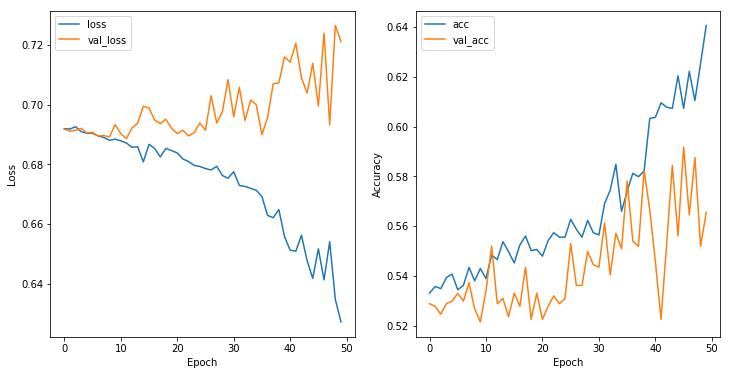

In [32]:
plot_result(history)

#### Window length 30 | Patience 5

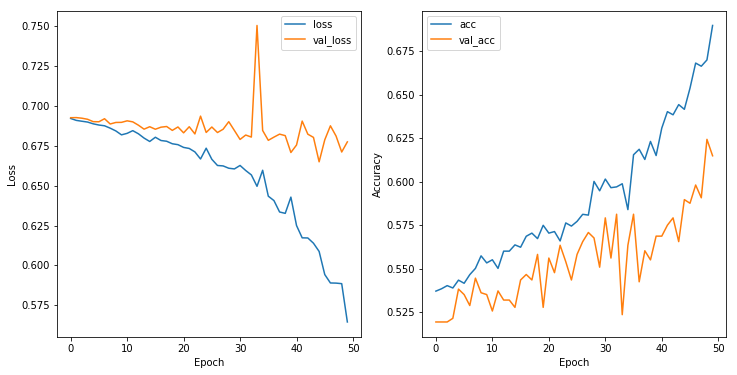

In [40]:
plot_result(history)

#### Window length 30 | Patience 7

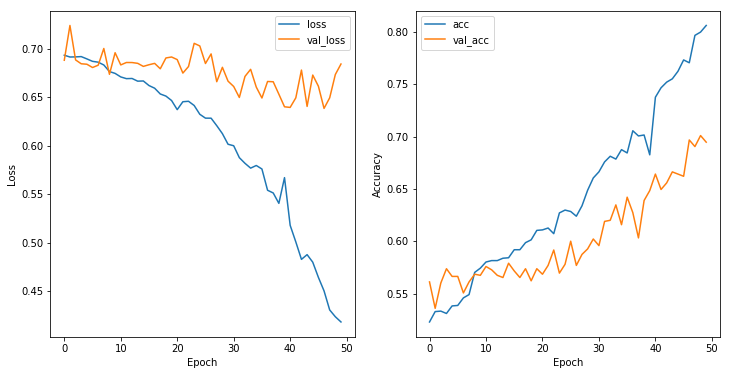

In [48]:
plot_result(history)

#### Window length 30 | Patience 10

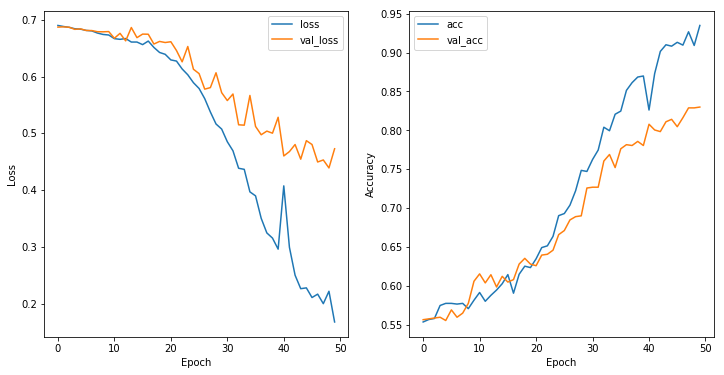

In [56]:
plot_result(history)

#### Window length 30 | Patience 15

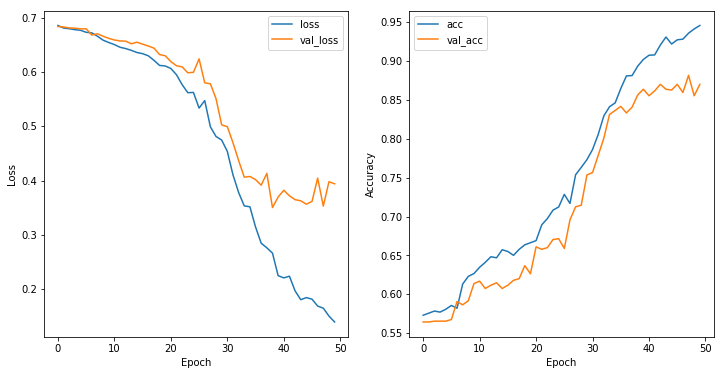

In [63]:
plot_result(history)

#### Conclusion:
Longer the patience window gives better result, which also leads to issues. If the overall market is an upward trend, then longer window definetely give you better estimation of the market.

Thus, taking the patience window too long might not be a good estimation, I take 7 window patience.

#### Firstly check how many increase there in the data set(too much 1 makes an imbalance data set, in which accuracy can be misleading)

In [77]:
sum(y_test)/float(len(y_test))

0.5498426023084995

### Prediction
Check the correlation of the prediction probability and the actual label

In [86]:
y_prob = model.predict_proba(X_test)
y_pred = model.predict_classes(X_test)
df = pd.DataFrame({'y_true': y_test, 'y_prob': np.squeeze(y_prob), 'y_pred': np.squeeze(y_pred)})

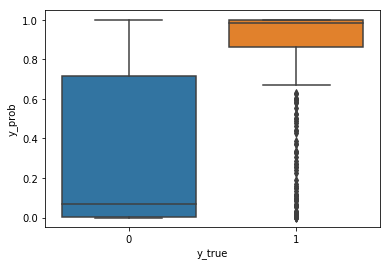

In [81]:
sns.boxplot(data=df, x='y_true', y='y_prob')

##### Insight:
Very few cases label 1 with very low prob and label 0 with very high prob

##### Confusion Matrix

In [88]:
pd.crosstab(df['y_true'], df['y_pred'], rownames=['True'], colnames=['Predicted'])

Predicted,0,1
True,,
0,299,130
1,71,453


In [92]:
print 'Precision of predicted 1 is {0:.3f}'.format(453./(130+453))
print 'Precision of predicted 0 is {0:.3f}'.format(299./(299+71))
print 'Total accuracy is {0:.3f}'.format((299.+453)/(130+453+299+71))

Precision of predicted 1 is 0.777
Precision of predicted 0 is 0.808
Total accuracy is 0.789


#### Compare to all models built before, longer the patience window doesn't increase overfitting too much

### Save model wights

In [122]:
import json
from keras.models import model_from_json

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [123]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")